In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/My Drive/DL-from-scratch"

/content/drive/My Drive/DL-from-scratch


In [ ]:
! git clone https://github.com/WegraLee/deep-learning-from-scratch.git

Cloning into 'deep-learning-from-scratch'...
remote: Enumerating objects: 826, done.
remote: Total 826 (delta 0), reused 0 (delta 0), pack-reused 826
Receiving objects: 100% (826/826), 52.21 MiB | 19.67 MiB/s, done.
Resolving deltas: 100% (477/477), done.


# CHAPTER 6. 학습 관련 기술들


### 6.1 매개변수 갱신


**최적화**: 손실 함수의 값을 가능한 한 낮추는 최적 매개변수를 찾는 문제, 이는 *신경망 학습의 목적*이기도 함.



#### 확률적 경사 하강법

매개변수의 기울기를 구해 기울어진 방향으로 매개변수 값을 갱신하는 일을 몇번이고 반복해서 최적의 매개변수로 다가가는 방법

- 단점: 비등방성 함수(방향에 따라 성질_기울기 등이 달라지는 함수)에서는 탐색 경로가 비효율적임
- SGD 대체 비법: 모멘텀, AdaGrad, Adam

In [ ]:
#확률적 경사 하강법(SGD)

class SGD:

    """확률적 경사 하강법（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 




#### 모멘텀

SGD에 비해 '지그재그 정도'가 덜함.

In [ ]:
 class Momentum:

    """모멘텀 SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]


class Nesterov:

    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""
    # NAG는 모멘텀에서 한 단계 발전한 방법이다. (http://newsight.tistory.com/224)
    
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]

#### AdaGrad

learning rate decay(학습률 감소)? 학습을 진행하면서 학습률을 점차 줄여가는 방법

학습률을 서서히 낮추는 가장 간단한 방법은 매개변수'전체'의 학습률 값을 일괄적으로 낮추는 것임. 이를 발전시킨 개념이 AdaGrad임!

AdaGrad는 과거의 기울기를 제곱하여 계속 더해가므로, **학습을 진행할수록 갱신 강도가 약해짐** 
- 실제로 무한히 계속 학습할 시 어느 순간 갱신량이 0이 됨
- 개선) RMSProp:과거의 모든 기울기를 균일하게 더해가는 것이 아니라 과거의 기울기는 잊고 새로운 기울기 정보를 크게 반영함

In [ ]:
class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


class RMSprop:

    """RMSprop"""

    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

#### Adam

직관적으로는 모멘템과 AdaGrad를 융합한 듯한 방법
- 매개변수 공간의 효율적 탐색 기대
- 하이퍼파라미터의 '편향 보정'진행

In [ ]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

#### 매개변수 갱신 방법 간의 비교

각자 상황을 고려하여 시도해보세용^_^

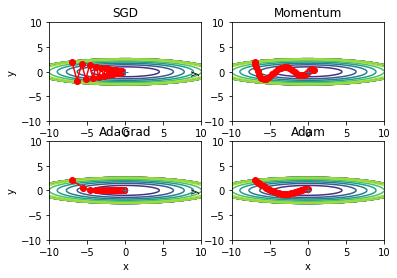

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
#from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

#### MNIST 데이터셋으로 본 갱신 방법 비교



In [ ]:
 sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '..',
 '/content/drive/My Drive/DL-from-scratch/deep-learning-from-scratch',
 '/content/drive/My Drive/DL-from-scratch/deep-learning-from-scratch',
 '/content/drive/My Drive/DL-from-scratch/deep-learning-from-scratch',
 '/content/drive/My Drive/DL-from-scratch/deep-learning-from-scratch/common',
 '/content/drive/My Drive/DL-from-scratch/deep-learning-from-scratch/dataset']

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!
===========iteration:0===========
SGD:2.3369375545830957
Momentum:2.3854091175919963
AdaGrad:2.1015990139187686
Adam:2.171442103016367
===========iteration:100===========
SGD:1.4254106779569968
Momentum:0.41786820342939945
AdaGrad:0.14748858665398878
Adam:0.26542592409227694
===========iteration:200===========
SGD:0.7348366981598081
Momentum:0.2855678762210981
AdaGrad:0.10853512594856052
Adam:0.18475392752025555
===========iteration:300===========
SGD:0.5567843843993971
Momentum:0.22725042251923028
AdaGrad:0.1366698529721082
Adam:0.1841618731535244
===========iteration:400===========
SGD:0.5693368282972442
Momentum:0.23976191419612017
AdaGrad:0.09663824805390128
Adam:0.13273292909339351
===========iteration:500===

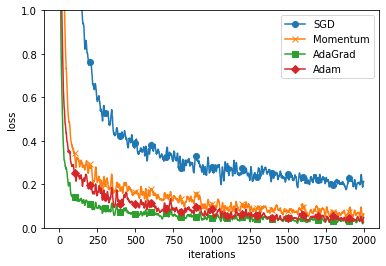

In [ ]:
import os
import sys
sys.path.append("/content/drive/My Drive/DL-from-scratch/deep-learning-from-scratch") # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *

#import matplotlib.pyplot as plt  # 그림으로 보기 위한 matplotlib 라이브러리 import
#from tensorflow.keras.datasets import mnist  # 라이브러리가 기본으로 제공하는 mnist 데이터셋
#from tensorflow.keras.utils import to_categorical  # one-hot encoding 을 위한 함수
#from tensorflow.keras.models import Sequential  # 레이어를 층층히 쌓아가는 연쇄 모델
#from tensorflow.keras.layers import Dense  # 완전연결층
#from tensorflow.keras.models import load_model  # 저장된 모델 불러오기


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
#(x_train,  t_train), (x_test, t_test) = mnist.load_data()
train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

일반적으로 SGD보다 다른 세 기법이 빠르게 학습하는 편

### 6.2 가중치의 초깃값

**가중치 감소?** 가중치 매개변수의 값이 작아지도록 학습하는 방법

- 가중치의 초깃값을 모두 0으로 하면, 오차역전파법에서 모든 가중치 값이 똑같이 갱신되기 때문에 학습이 올바로 이뤄지지 않음.
- 가중치의 초깃값은 무작위로 설정해야함.  

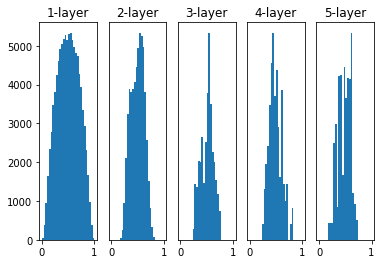

In [ ]:
#은닉층의 활성화값 분포

# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    #w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num) #Xavier 초깃값
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

데이터가 0과 1에 치우쳐 분포하게 되면 역전파의 기울기 값이 점점 작아지다가 사라지는 **기울기 소실** 문제 발생

표준편차를 0.01로 한 정규분포의 경우, 각 층의 활성화 값은 0.5부근에 집중됨

활성화 값들이 치우치면 **표현력을 제한**하게됨. 

Xavier 초깃값: 초깃값의 표준편차가 1/sqrt(n) 이 되도록 설정

In [1]:
import sys, os


In [5]:
 sys.path

['C:\\Users\\minjuKim\\Desktop\\[FIN_AI]_study_myself',
 'C:\\ProgramData\\Anaconda3\\python38.zip',
 'C:\\ProgramData\\Anaconda3\\DLLs',
 'C:\\ProgramData\\Anaconda3\\lib',
 'C:\\ProgramData\\Anaconda3',
 '',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\Pythonwin',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\minjuKim\\.ipython',
 'C://Users//minjuKim//Desktop//[FIN_AI]_study_myself//deep-learning-from-scratch-master']

In [4]:
sys.path.append("C://Users//minjuKim//Desktop//[FIN_AI]_study_myself//deep-learning-from-scratch-master")  

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!
===========iteration:0===========
std=0.01:2.3025085579371005
Xavier:2.300097430819234
He:2.2983378169000357
===========iteration:100===========
std=0.01:2.3016984504223643
Xavier:2.2480171712784704
He:1.7018557086511277
===========iteration:200===========
std=0.01:2.3020517251459442
Xavier:2.1226822461708625
He:0.8155537243373927
===========iteration:300===========
std=0.01:2.302144304524646
Xavier:1.8684028797092591
He:0.5588067447361159
===========iteration:400===========
std=0.01:2.3017613526239225
Xavier:1.3443693267979229
He:0.4228468524900549
===========iteration:500===========
std=0.01:2.3024888510433152
Xavier:0.9016617259134159
He:0.3414957616144741
===========iteration:600===========
std=0.01:2.29647977

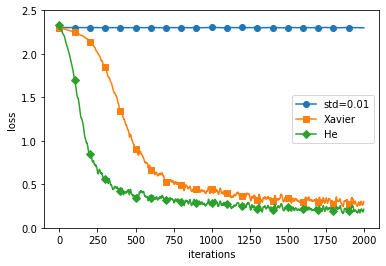

In [6]:
#MNIST 데이터셋으로 본 가중치 초깃값의 비교

import os
import sys

#sys.path.append("/content/drive/My Drive/DL-from-scratch/deep-learning-from-scratch/dataset")  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()


### 6.3 배치 정규화

배치 정규화: 각 층이 활성화를 적당히 퍼뜨리도록 강제하는 것.

배치 정규화가 주목받는 이유
- 학습 속도 개선
- 초깃값에 크게 의존하지 않음
- 오버피팅 억제

============== 1/16 ==============
epoch:0 | 0.092 - 0.094
epoch:1 | 0.097 - 0.116


C://Users//minjuKim//Desktop//[FIN_AI]_study_myself//deep-learning-from-scratch-master\common\multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
C://Users//minjuKim//Desktop//[FIN_AI]_study_myself//deep-learning-from-scratch-master\common\multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:2 | 0.097 - 0.139
epoch:3 | 0.097 - 0.168
epoch:4 | 0.097 - 0.185
epoch:5 | 0.097 - 0.198
epoch:6 | 0.097 - 0.215
epoch:7 | 0.097 - 0.228
epoch:8 | 0.097 - 0.239
epoch:9 | 0.097 - 0.256
epoch:10 | 0.097 - 0.272
epoch:11 | 0.097 - 0.285
epoch:12 | 0.097 - 0.297
epoch:13 | 0.097 - 0.314
epoch:14 | 0.097 - 0.327
epoch:15 | 0.097 - 0.336
epoch:16 | 0.097 - 0.351
epoch:17 | 0.097 - 0.36
epoch:18 | 0.097 - 0.366


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.382
============== 2/16 ==============
epoch:0 | 0.099 - 0.102


C://Users//minjuKim//Desktop//[FIN_AI]_study_myself//deep-learning-from-scratch-master\common\multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C://Users//minjuKim//Desktop//[FIN_AI]_study_myself//deep-learning-from-scratch-master\common\multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
C://Users//minjuKim//Desktop//[FIN_AI]_study_myself//deep-learning-from-scratch-master\common\functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


epoch:1 | 0.097 - 0.102
epoch:2 | 0.097 - 0.142
epoch:3 | 0.097 - 0.156
epoch:4 | 0.097 - 0.178
epoch:5 | 0.097 - 0.199
epoch:6 | 0.097 - 0.209
epoch:7 | 0.097 - 0.234
epoch:8 | 0.097 - 0.249
epoch:9 | 0.097 - 0.273
epoch:10 | 0.097 - 0.297
epoch:11 | 0.097 - 0.312
epoch:12 | 0.097 - 0.345
epoch:13 | 0.097 - 0.365
epoch:14 | 0.097 - 0.393
epoch:15 | 0.097 - 0.427
epoch:16 | 0.097 - 0.44
epoch:17 | 0.097 - 0.44
epoch:18 | 0.097 - 0.473


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.487
============== 3/16 ==============
epoch:0 | 0.106 - 0.147
epoch:1 | 0.471 - 0.144
epoch:2 | 0.59 - 0.156
epoch:3 | 0.695 - 0.185
epoch:4 | 0.73 - 0.225
epoch:5 | 0.809 - 0.26
epoch:6 | 0.827 - 0.304
epoch:7 | 0.891 - 0.334
epoch:8 | 0.912 - 0.369
epoch:9 | 0.93 - 0.394
epoch:10 | 0.942 - 0.409
epoch:11 | 0.961 - 0.437
epoch:12 | 0.968 - 0.478
epoch:13 | 0.975 - 0.505
epoch:14 | 0.981 - 0.521
epoch:15 | 0.986 - 0.535
epoch:16 | 0.989 - 0.559
epoch:17 | 0.995 - 0.575
epoch:18 | 0.996 - 0.597


No handles with labels found to put in legend.


epoch:19 | 0.996 - 0.605
============== 4/16 ==============
epoch:0 | 0.132 - 0.103
epoch:1 | 0.3 - 0.088
epoch:2 | 0.444 - 0.186
epoch:3 | 0.565 - 0.253
epoch:4 | 0.613 - 0.336
epoch:5 | 0.658 - 0.428
epoch:6 | 0.689 - 0.475
epoch:7 | 0.708 - 0.527
epoch:8 | 0.733 - 0.559
epoch:9 | 0.761 - 0.6
epoch:10 | 0.785 - 0.622
epoch:11 | 0.788 - 0.658
epoch:12 | 0.802 - 0.686
epoch:13 | 0.815 - 0.708
epoch:14 | 0.837 - 0.726
epoch:15 | 0.849 - 0.737
epoch:16 | 0.848 - 0.75
epoch:17 | 0.856 - 0.767
epoch:18 | 0.859 - 0.783


No handles with labels found to put in legend.


epoch:19 | 0.875 - 0.794
============== 5/16 ==============
epoch:0 | 0.097 - 0.084
epoch:1 | 0.111 - 0.178
epoch:2 | 0.11 - 0.347
epoch:3 | 0.112 - 0.481
epoch:4 | 0.142 - 0.551
epoch:5 | 0.163 - 0.613
epoch:6 | 0.184 - 0.653
epoch:7 | 0.195 - 0.693
epoch:8 | 0.21 - 0.727
epoch:9 | 0.207 - 0.762
epoch:10 | 0.202 - 0.782
epoch:11 | 0.222 - 0.803
epoch:12 | 0.228 - 0.827
epoch:13 | 0.212 - 0.838
epoch:14 | 0.209 - 0.857
epoch:15 | 0.213 - 0.861
epoch:16 | 0.213 - 0.87
epoch:17 | 0.204 - 0.878
epoch:18 | 0.211 - 0.884


No handles with labels found to put in legend.


epoch:19 | 0.23 - 0.891
============== 6/16 ==============
epoch:0 | 0.117 - 0.107
epoch:1 | 0.116 - 0.223
epoch:2 | 0.127 - 0.419
epoch:3 | 0.115 - 0.565
epoch:4 | 0.115 - 0.649
epoch:5 | 0.115 - 0.705
epoch:6 | 0.14 - 0.757
epoch:7 | 0.125 - 0.786
epoch:8 | 0.127 - 0.81
epoch:9 | 0.116 - 0.841
epoch:10 | 0.116 - 0.856
epoch:11 | 0.116 - 0.888
epoch:12 | 0.116 - 0.892
epoch:13 | 0.116 - 0.906
epoch:14 | 0.116 - 0.917
epoch:15 | 0.116 - 0.923
epoch:16 | 0.116 - 0.931
epoch:17 | 0.116 - 0.937
epoch:18 | 0.116 - 0.945


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.946
============== 7/16 ==============
epoch:0 | 0.105 - 0.113
epoch:1 | 0.117 - 0.315
epoch:2 | 0.116 - 0.559
epoch:3 | 0.116 - 0.692
epoch:4 | 0.116 - 0.738
epoch:5 | 0.116 - 0.769
epoch:6 | 0.117 - 0.809
epoch:7 | 0.117 - 0.847
epoch:8 | 0.117 - 0.875
epoch:9 | 0.117 - 0.897
epoch:10 | 0.117 - 0.915
epoch:11 | 0.117 - 0.931
epoch:12 | 0.117 - 0.937
epoch:13 | 0.116 - 0.951
epoch:14 | 0.116 - 0.96
epoch:15 | 0.116 - 0.961
epoch:16 | 0.116 - 0.967
epoch:17 | 0.116 - 0.972
epoch:18 | 0.117 - 0.975


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.983
============== 8/16 ==============
epoch:0 | 0.099 - 0.138
epoch:1 | 0.099 - 0.412
epoch:2 | 0.117 - 0.667
epoch:3 | 0.116 - 0.744
epoch:4 | 0.116 - 0.796
epoch:5 | 0.116 - 0.851
epoch:6 | 0.116 - 0.883
epoch:7 | 0.116 - 0.895
epoch:8 | 0.116 - 0.929
epoch:9 | 0.116 - 0.948
epoch:10 | 0.116 - 0.961
epoch:11 | 0.116 - 0.974
epoch:12 | 0.117 - 0.979
epoch:13 | 0.117 - 0.981
epoch:14 | 0.117 - 0.988
epoch:15 | 0.117 - 0.993
epoch:16 | 0.116 - 0.996
epoch:17 | 0.117 - 0.996
epoch:18 | 0.117 - 0.998


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.998
============== 9/16 ==============
epoch:0 | 0.105 - 0.159
epoch:1 | 0.117 - 0.534
epoch:2 | 0.099 - 0.755
epoch:3 | 0.117 - 0.812
epoch:4 | 0.117 - 0.85
epoch:5 | 0.117 - 0.879
epoch:6 | 0.117 - 0.884
epoch:7 | 0.117 - 0.894
epoch:8 | 0.117 - 0.899
epoch:9 | 0.117 - 0.904
epoch:10 | 0.117 - 0.916
epoch:11 | 0.117 - 0.968
epoch:12 | 0.117 - 0.997
epoch:13 | 0.117 - 1.0
epoch:14 | 0.117 - 1.0
epoch:15 | 0.117 - 1.0
epoch:16 | 0.117 - 1.0
epoch:17 | 0.117 - 1.0
epoch:18 | 0.117 - 1.0


No handles with labels found to put in legend.


epoch:19 | 0.117 - 1.0
============== 10/16 ==============
epoch:0 | 0.087 - 0.099
epoch:1 | 0.117 - 0.68
epoch:2 | 0.117 - 0.831
epoch:3 | 0.116 - 0.856
epoch:4 | 0.116 - 0.915
epoch:5 | 0.117 - 0.926
epoch:6 | 0.116 - 0.968
epoch:7 | 0.117 - 0.969
epoch:8 | 0.116 - 0.951
epoch:9 | 0.116 - 0.988
epoch:10 | 0.116 - 0.992
epoch:11 | 0.117 - 0.995
epoch:12 | 0.116 - 0.994
epoch:13 | 0.116 - 0.994
epoch:14 | 0.116 - 0.996
epoch:15 | 0.117 - 0.96
epoch:16 | 0.117 - 0.989
epoch:17 | 0.117 - 0.996
epoch:18 | 0.117 - 0.998


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.998
============== 11/16 ==============
epoch:0 | 0.116 - 0.142
epoch:1 | 0.116 - 0.54
epoch:2 | 0.117 - 0.661
epoch:3 | 0.117 - 0.729
epoch:4 | 0.117 - 0.771
epoch:5 | 0.116 - 0.864
epoch:6 | 0.116 - 0.893
epoch:7 | 0.116 - 0.799
epoch:8 | 0.117 - 0.705
epoch:9 | 0.117 - 0.883
epoch:10 | 0.117 - 0.912
epoch:11 | 0.117 - 0.889
epoch:12 | 0.117 - 0.899
epoch:13 | 0.117 - 0.872
epoch:14 | 0.117 - 0.947
epoch:15 | 0.117 - 0.971
epoch:16 | 0.117 - 0.966
epoch:17 | 0.117 - 0.972
epoch:18 | 0.117 - 0.985


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.989
============== 12/16 ==============
epoch:0 | 0.116 - 0.233
epoch:1 | 0.116 - 0.501
epoch:2 | 0.117 - 0.671
epoch:3 | 0.116 - 0.553
epoch:4 | 0.116 - 0.775
epoch:5 | 0.116 - 0.757
epoch:6 | 0.116 - 0.747
epoch:7 | 0.116 - 0.875
epoch:8 | 0.116 - 0.864
epoch:9 | 0.116 - 0.867
epoch:10 | 0.116 - 0.93
epoch:11 | 0.116 - 0.872
epoch:12 | 0.116 - 0.913
epoch:13 | 0.116 - 0.963
epoch:14 | 0.116 - 0.967
epoch:15 | 0.116 - 0.986
epoch:16 | 0.116 - 0.984
epoch:17 | 0.116 - 0.987
epoch:18 | 0.116 - 0.987


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.987
============== 13/16 ==============
epoch:0 | 0.105 - 0.125
epoch:1 | 0.116 - 0.57
epoch:2 | 0.116 - 0.54
epoch:3 | 0.116 - 0.677
epoch:4 | 0.116 - 0.737
epoch:5 | 0.116 - 0.76
epoch:6 | 0.116 - 0.78
epoch:7 | 0.116 - 0.743
epoch:8 | 0.116 - 0.754
epoch:9 | 0.116 - 0.785
epoch:10 | 0.116 - 0.794
epoch:11 | 0.116 - 0.873
epoch:12 | 0.116 - 0.886
epoch:13 | 0.116 - 0.887
epoch:14 | 0.116 - 0.89
epoch:15 | 0.116 - 0.89
epoch:16 | 0.116 - 0.798
epoch:17 | 0.116 - 0.867
epoch:18 | 0.116 - 0.892


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.893
============== 14/16 ==============
epoch:0 | 0.116 - 0.065
epoch:1 | 0.116 - 0.376
epoch:2 | 0.116 - 0.38
epoch:3 | 0.116 - 0.449
epoch:4 | 0.116 - 0.453
epoch:5 | 0.116 - 0.484
epoch:6 | 0.116 - 0.503
epoch:7 | 0.116 - 0.485
epoch:8 | 0.117 - 0.5
epoch:9 | 0.116 - 0.506
epoch:10 | 0.116 - 0.514
epoch:11 | 0.116 - 0.506
epoch:12 | 0.116 - 0.509
epoch:13 | 0.116 - 0.5
epoch:14 | 0.116 - 0.521
epoch:15 | 0.116 - 0.517
epoch:16 | 0.116 - 0.513
epoch:17 | 0.116 - 0.516
epoch:18 | 0.116 - 0.516


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.517
============== 15/16 ==============
epoch:0 | 0.092 - 0.099
epoch:1 | 0.116 - 0.317
epoch:2 | 0.116 - 0.406
epoch:3 | 0.116 - 0.393
epoch:4 | 0.117 - 0.418
epoch:5 | 0.117 - 0.424
epoch:6 | 0.117 - 0.424
epoch:7 | 0.117 - 0.43
epoch:8 | 0.117 - 0.428
epoch:9 | 0.117 - 0.43
epoch:10 | 0.117 - 0.43
epoch:11 | 0.116 - 0.431
epoch:12 | 0.116 - 0.431
epoch:13 | 0.116 - 0.432
epoch:14 | 0.116 - 0.431
epoch:15 | 0.116 - 0.433
epoch:16 | 0.116 - 0.432
epoch:17 | 0.116 - 0.432
epoch:18 | 0.117 - 0.52


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.522
============== 16/16 ==============
epoch:0 | 0.116 - 0.169
epoch:1 | 0.116 - 0.211
epoch:2 | 0.116 - 0.312
epoch:3 | 0.116 - 0.3
epoch:4 | 0.116 - 0.37
epoch:5 | 0.116 - 0.373
epoch:6 | 0.116 - 0.405
epoch:7 | 0.116 - 0.382
epoch:8 | 0.116 - 0.398
epoch:9 | 0.116 - 0.375
epoch:10 | 0.116 - 0.404
epoch:11 | 0.116 - 0.406
epoch:12 | 0.116 - 0.425
epoch:13 | 0.116 - 0.431
epoch:14 | 0.116 - 0.414
epoch:15 | 0.116 - 0.43
epoch:16 | 0.116 - 0.435
epoch:17 | 0.116 - 0.431
epoch:18 | 0.116 - 0.429
epoch:19 | 0.116 - 0.425


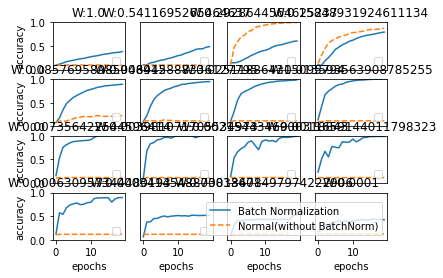

In [7]:
import sys, os
#sys.path.append(C:/Users/minjuKim/Desktop/[FIN_AI]_study_myself/deep-learning-from-scratch-master)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

거의 모든 경우에서 배치 정규화를 사용할 떄 학습 진도가 빠름. <br>
실제로 배치정규화를 이용하지 않는 경우 초깃값이 잘 분포되어 있지 않으면 학습이 전혀 진행되지 않는 모습도 확인 가능

### 6.4 바른 학습을 위해

오버피팅이 일어나는 경우

- 매개변수가 많고 표현력이 높은 모델
- 훈련 데이터가 적음

epoch:0, train acc:0.09, test acc:0.1045
epoch:1, train acc:0.10666666666666667, test acc:0.1084
epoch:2, train acc:0.11333333333333333, test acc:0.1142
epoch:3, train acc:0.12333333333333334, test acc:0.1233
epoch:4, train acc:0.13666666666666666, test acc:0.131
epoch:5, train acc:0.16666666666666666, test acc:0.1454
epoch:6, train acc:0.20333333333333334, test acc:0.169
epoch:7, train acc:0.27666666666666667, test acc:0.2048
epoch:8, train acc:0.34, test acc:0.2415
epoch:9, train acc:0.37333333333333335, test acc:0.269
epoch:10, train acc:0.44333333333333336, test acc:0.3265
epoch:11, train acc:0.48333333333333334, test acc:0.3551
epoch:12, train acc:0.5333333333333333, test acc:0.3823
epoch:13, train acc:0.5533333333333333, test acc:0.4243
epoch:14, train acc:0.59, test acc:0.4589
epoch:15, train acc:0.6066666666666667, test acc:0.4803
epoch:16, train acc:0.6166666666666667, test acc:0.4971
epoch:17, train acc:0.6166666666666667, test acc:0.4966
epoch:18, train acc:0.64, test acc:0.

epoch:172, train acc:1.0, test acc:0.7468
epoch:173, train acc:1.0, test acc:0.7463
epoch:174, train acc:1.0, test acc:0.7478
epoch:175, train acc:1.0, test acc:0.7458
epoch:176, train acc:1.0, test acc:0.7456
epoch:177, train acc:1.0, test acc:0.7468
epoch:178, train acc:1.0, test acc:0.747
epoch:179, train acc:1.0, test acc:0.7447
epoch:180, train acc:1.0, test acc:0.7461
epoch:181, train acc:1.0, test acc:0.746
epoch:182, train acc:1.0, test acc:0.7467
epoch:183, train acc:1.0, test acc:0.7465
epoch:184, train acc:1.0, test acc:0.7464
epoch:185, train acc:1.0, test acc:0.7465
epoch:186, train acc:1.0, test acc:0.7483
epoch:187, train acc:1.0, test acc:0.7469
epoch:188, train acc:1.0, test acc:0.747
epoch:189, train acc:1.0, test acc:0.7464
epoch:190, train acc:1.0, test acc:0.7473
epoch:191, train acc:1.0, test acc:0.7478
epoch:192, train acc:1.0, test acc:0.7477
epoch:193, train acc:1.0, test acc:0.7471
epoch:194, train acc:1.0, test acc:0.7466
epoch:195, train acc:1.0, test acc:0.

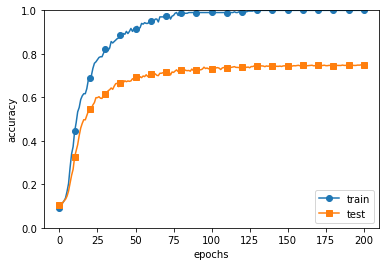

In [9]:

from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

#################################################
# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임#
#################################################
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우

# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


정확도 차이가 크게 벌어지는 것은 훈련 데이터에만 적응해버린 결과임. <br>

훈련 때 사용하지 않은 범용 데이터(시험 데이터)에는 제대로 대응하지 못함. 

#### 오버 피팅 억제를 위한 수단_가중치 감소

**가중치 감소**? 학습 과정에서 큰 가중치에 대해서는 그에 상응하는 큰 패널티를 부과하여 오버피팅을 억제하는 방법

epoch:0, train acc:0.09, test acc:0.1102
epoch:1, train acc:0.10666666666666667, test acc:0.1141
epoch:2, train acc:0.11, test acc:0.1156
epoch:3, train acc:0.11333333333333333, test acc:0.1195
epoch:4, train acc:0.12666666666666668, test acc:0.1252
epoch:5, train acc:0.16, test acc:0.1391
epoch:6, train acc:0.19, test acc:0.1574
epoch:7, train acc:0.2, test acc:0.1803
epoch:8, train acc:0.25333333333333335, test acc:0.2013
epoch:9, train acc:0.27666666666666667, test acc:0.2186
epoch:10, train acc:0.3, test acc:0.2357
epoch:11, train acc:0.34, test acc:0.2638
epoch:12, train acc:0.3466666666666667, test acc:0.2749
epoch:13, train acc:0.37, test acc:0.2816
epoch:14, train acc:0.38333333333333336, test acc:0.2967
epoch:15, train acc:0.4, test acc:0.3075
epoch:16, train acc:0.4166666666666667, test acc:0.3111
epoch:17, train acc:0.43, test acc:0.3258
epoch:18, train acc:0.45666666666666667, test acc:0.3363
epoch:19, train acc:0.45666666666666667, test acc:0.3373
epoch:20, train acc:0.493

epoch:159, train acc:0.8866666666666667, test acc:0.7218
epoch:160, train acc:0.8866666666666667, test acc:0.7217
epoch:161, train acc:0.8933333333333333, test acc:0.7167
epoch:162, train acc:0.87, test acc:0.7144
epoch:163, train acc:0.89, test acc:0.7078
epoch:164, train acc:0.8733333333333333, test acc:0.7041
epoch:165, train acc:0.8866666666666667, test acc:0.7099
epoch:166, train acc:0.8833333333333333, test acc:0.7083
epoch:167, train acc:0.88, test acc:0.7035
epoch:168, train acc:0.8866666666666667, test acc:0.7042
epoch:169, train acc:0.8866666666666667, test acc:0.7088
epoch:170, train acc:0.8833333333333333, test acc:0.7114
epoch:171, train acc:0.88, test acc:0.7069
epoch:172, train acc:0.8866666666666667, test acc:0.706
epoch:173, train acc:0.88, test acc:0.7087
epoch:174, train acc:0.8866666666666667, test acc:0.7028
epoch:175, train acc:0.8733333333333333, test acc:0.7076
epoch:176, train acc:0.8833333333333333, test acc:0.7145
epoch:177, train acc:0.88, test acc:0.7145
ep

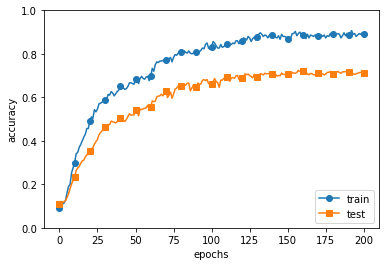

In [10]:
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

#### 드롭아웃

드롭아웃: 뉴런을 임의로 삭제하면서 학습하는 방법. 훈련 때 은닉층의 뉴런을 무작위로 골라 삭제함. 시험때는 모든 뉴런에 신호를 전달하는 대신 각 뉴런의 출력에 훈련 때 삭제한 비율을 곱하여 훈련함. 

train loss:2.2880734493896537
=== epoch:1, train acc:0.11, test acc:0.1049 ===
train loss:2.2875732604419063
train loss:2.2857522778661776
train loss:2.2905182167746516
=== epoch:2, train acc:0.13, test acc:0.1083 ===
train loss:2.296295211737728
train loss:2.293051013737019
train loss:2.287898768246538
=== epoch:3, train acc:0.13, test acc:0.1122 ===
train loss:2.2868565425110763
train loss:2.283361216264783
train loss:2.2971879251259573
=== epoch:4, train acc:0.13333333333333333, test acc:0.1167 ===
train loss:2.2804591819821063
train loss:2.289784428179591
train loss:2.2819407985134608
=== epoch:5, train acc:0.13, test acc:0.1208 ===
train loss:2.2769914000820144
train loss:2.2782119510665795
train loss:2.278241393943965
=== epoch:6, train acc:0.13333333333333333, test acc:0.125 ===
train loss:2.273494856222778
train loss:2.2927234740116313
train loss:2.286721745182232
=== epoch:7, train acc:0.13666666666666666, test acc:0.1305 ===
train loss:2.2749687114999344
train loss:2.28133742

=== epoch:57, train acc:0.31333333333333335, test acc:0.2441 ===
train loss:2.181122645253557
train loss:2.2236987985598784
train loss:2.196835193257917
=== epoch:58, train acc:0.32, test acc:0.2425 ===
train loss:2.204994562322578
train loss:2.213261841084076
train loss:2.1839602234465927
=== epoch:59, train acc:0.32, test acc:0.241 ===
train loss:2.216683731788612
train loss:2.2237937480488763
train loss:2.1861020612225253
=== epoch:60, train acc:0.31666666666666665, test acc:0.2418 ===
train loss:2.231428407924137
train loss:2.198820511178645
train loss:2.2002160684807217
=== epoch:61, train acc:0.3233333333333333, test acc:0.2443 ===
train loss:2.186634004963414
train loss:2.1894038006426615
train loss:2.192649096890242
=== epoch:62, train acc:0.32, test acc:0.2354 ===
train loss:2.187792722644097
train loss:2.210753053523636
train loss:2.2068469111281064
=== epoch:63, train acc:0.32, test acc:0.2406 ===
train loss:2.206518143421005
train loss:2.203271759929944
train loss:2.2071808

=== epoch:113, train acc:0.4066666666666667, test acc:0.3205 ===
train loss:2.087401966245992
train loss:2.0521146834177237
train loss:2.08646861604968
=== epoch:114, train acc:0.41, test acc:0.3265 ===
train loss:2.0930094971650073
train loss:2.047574545077698
train loss:2.026543024882724
=== epoch:115, train acc:0.41333333333333333, test acc:0.3217 ===
train loss:2.0134856342173126
train loss:2.0297074857005684
train loss:2.0537956556745747
=== epoch:116, train acc:0.42333333333333334, test acc:0.3294 ===
train loss:2.1003990487070836
train loss:2.031798921730447
train loss:2.092280031673277
=== epoch:117, train acc:0.44, test acc:0.3358 ===
train loss:2.0800778169468326
train loss:2.0482955326206436
train loss:2.014506790591629
=== epoch:118, train acc:0.44, test acc:0.3356 ===
train loss:2.094702059744514
train loss:2.022512918571343
train loss:2.0624338964423803
=== epoch:119, train acc:0.44, test acc:0.3402 ===
train loss:2.0288127604413173
train loss:2.056630748037274
train loss

=== epoch:168, train acc:0.5066666666666667, test acc:0.4206 ===
train loss:1.6662337137025662
train loss:1.698617928933622
train loss:1.7504584675728816
=== epoch:169, train acc:0.5066666666666667, test acc:0.4191 ===
train loss:1.7695446888355248
train loss:1.7180681336599226
train loss:1.6778792585352602
=== epoch:170, train acc:0.5, test acc:0.4215 ===
train loss:1.6278039916389353
train loss:1.6744105906368671
train loss:1.5895431850568857
=== epoch:171, train acc:0.5233333333333333, test acc:0.4287 ===
train loss:1.8175626724747977
train loss:1.6527550159616964
train loss:1.7496708124756244
=== epoch:172, train acc:0.5133333333333333, test acc:0.4317 ===
train loss:1.6533175666886109
train loss:1.5531446875040316
train loss:1.626134224805976
=== epoch:173, train acc:0.51, test acc:0.426 ===
train loss:1.6066798731167913
train loss:1.5970777376573455
train loss:1.68071680665264
=== epoch:174, train acc:0.51, test acc:0.4237 ===
train loss:1.6988013549868008
train loss:1.5528457378

=== epoch:223, train acc:0.64, test acc:0.512 ===
train loss:1.237166975624593
train loss:1.2280782593194188
train loss:1.1980387746183423
=== epoch:224, train acc:0.6366666666666667, test acc:0.5101 ===
train loss:1.2515347253891889
train loss:1.1921976233656468
train loss:1.2058768665064339
=== epoch:225, train acc:0.64, test acc:0.512 ===
train loss:1.2452573897525048
train loss:1.415744585139005
train loss:1.1796026952710692
=== epoch:226, train acc:0.6433333333333333, test acc:0.5097 ===
train loss:1.0438225959957905
train loss:1.1568335613219682
train loss:1.197637042912627
=== epoch:227, train acc:0.6366666666666667, test acc:0.5069 ===
train loss:1.2180259893129934
train loss:1.289363228508919
train loss:1.237208888740126
=== epoch:228, train acc:0.6366666666666667, test acc:0.5098 ===
train loss:1.2363533339393067
train loss:1.3354125940752903
train loss:1.318663119484583
=== epoch:229, train acc:0.6433333333333333, test acc:0.5119 ===
train loss:1.1361370989681427
train loss:

=== epoch:278, train acc:0.7133333333333334, test acc:0.5787 ===
train loss:0.8336589182226573
train loss:0.9335840425235677
train loss:0.8750265297393812
=== epoch:279, train acc:0.72, test acc:0.5822 ===
train loss:0.8414943826235537
train loss:0.8679282896826251
train loss:0.8900553562621273
=== epoch:280, train acc:0.7166666666666667, test acc:0.5772 ===
train loss:0.7900267166639616
train loss:0.8478252420994692
train loss:0.8811496822632324
=== epoch:281, train acc:0.7233333333333334, test acc:0.5808 ===
train loss:0.8956554803045274
train loss:0.8153601464665624
train loss:0.9480987825226508
=== epoch:282, train acc:0.7166666666666667, test acc:0.58 ===
train loss:0.8338324660657487
train loss:1.0639564507387718
train loss:0.7769356564972486
=== epoch:283, train acc:0.7166666666666667, test acc:0.5855 ===
train loss:0.7345403903099613
train loss:0.9834533085294342
train loss:0.8579365063344797
=== epoch:284, train acc:0.7166666666666667, test acc:0.581 ===
train loss:0.783453524

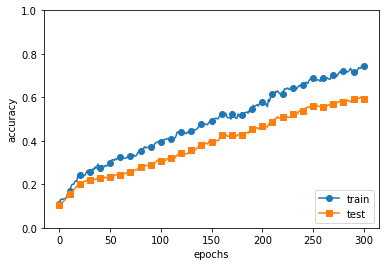

In [11]:
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### 6.5 적절한 하이퍼파라미터 값 찾기

하이퍼파라미터의 값을 최대한 효율적으로 탐색하는 방법

#### 검증 데이터

하이퍼파라미터의 적절성을 평가하는 데이터<br>
cf) 훈련데이터: 매개변수 학습 / 시험데이터: 신경망의 범용 성능 평가

In [12]:
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


#### 하이퍼파라미터 최적화

대략적으로 하이퍼파라미터의 범위를 지정하고, 그 범위에서 무작위로 하이퍼파라미터 값을 골라낸(샘플링) 후, 그 값으로 정확도를 평가함. 

**0단계**
하이퍼파라미터 값의 범위를 설정한다

**1단계**
설정된 범위에서 하이퍼파라미터의 값을 무작위로 추출한다

**2단계**
1단계에서 샘플링한 하이퍼파라미터값을 사용하여 학습하고, 검증 데이터로 정확도를 평가한다(단 에폭은 작게 설정)

**3단계**
1단계와 2단계를 특정 횟수(100회 등) 반복하며, 그 정확도의 결과를 보고 하이퍼파라미터의 범위를 좁힌다.


val acc:0.72 | lr:0.005310825563423368, weight decay:4.490080025136164e-07
val acc:0.05 | lr:3.054598032076353e-05, weight decay:6.314828413011092e-07
val acc:0.1 | lr:4.6853940538041865e-05, weight decay:1.6503806985676967e-06
val acc:0.1 | lr:2.0220114087735745e-05, weight decay:2.9484602973230055e-06
val acc:0.06 | lr:9.393275739957297e-06, weight decay:2.111308730448873e-08
val acc:0.17 | lr:0.0007105989755475537, weight decay:2.4775828450074127e-07
val acc:0.14 | lr:0.00032172488379237567, weight decay:1.7580435123422566e-08
val acc:0.1 | lr:1.4791187060542436e-06, weight decay:4.4916759194205997e-07
val acc:0.43 | lr:0.002736331803707412, weight decay:8.34834144301724e-07
val acc:0.45 | lr:0.003390721140599994, weight decay:1.701589720230694e-07
val acc:0.11 | lr:1.0975509991112418e-06, weight decay:8.000136946410095e-06
val acc:0.13 | lr:0.00031436284893319533, weight decay:1.7287991332181348e-05
val acc:0.14 | lr:5.816470241473657e-06, weight decay:9.6131896582189e-06
val acc:0

Best-14(val acc:0.45) | lr:0.001730832252883806, weight decay:5.8103731445319934e-08
Best-15(val acc:0.43) | lr:0.002736331803707412, weight decay:8.34834144301724e-07
Best-16(val acc:0.42) | lr:0.00297585102909862, weight decay:5.40702450546734e-05
Best-17(val acc:0.38) | lr:0.0018035459558511696, weight decay:1.241227393253522e-06
Best-18(val acc:0.3) | lr:0.0012154971811639886, weight decay:4.098340628292148e-05
Best-19(val acc:0.3) | lr:0.0020806545430025014, weight decay:4.0172296356330897e-07
Best-20(val acc:0.28) | lr:0.00222318493935014, weight decay:3.3773833631314916e-06


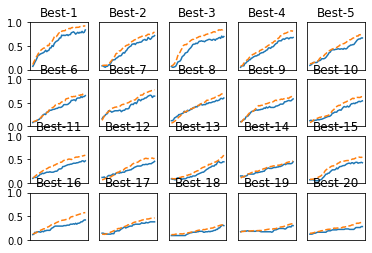

In [13]:
def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

학습이 잘 진행될 때의 학습률은 0.001~0.01, 가중치 감소 계수는 10^(-8) ~ 10^(-6) 정도라는 것을 알 수 있음. 

### 6.6 정리

### 이번 장에서 배운 것

* 매개변수 갱신 방법에는 확률적 경사 하강법(SGD) 외에도 모멘텀, AdaGrad, Adam 등이 있다.
* 가중치 초깃값을 정하는 방법은 올바른 학습을 하는 데 매우 중요하다.
* 가중치의 초깃값으로는 ‘Xavier 초깃값’과 ‘He 초깃값’이 효과적이다.
* 배치 정규화를 이용하면 학습을 빠르게 진행할 수 있으며, 초깃값에 영향을 덜 받게 된다.
* 오버피팅을 억제하는 정규화 기술로는 가중치 감소와 드롭아웃이 있다.
* 하이퍼파라미터 값 탐색은 최적 값이 존재할 법한 범위를 점차 좁히면서 하는 것이 효과적이다.